<h1><center>Birds classification Challenge : Object recognition and computer visions</center></h1>

### **Notebook guide**

The notebook consists of three main parts :


**part - 1** : The first part consists of implementing YOLO model (pretrained model) in order to detect the birds and crop the image.


**part - 2** : The second part consists of using Transfer Learning "MobileNet" model for the classification task. With the work done in the second part I could achieve 69% as accuracy on the test dataset.


**part - 3** : The final part consists of implementing (Vision Transformer) ViT model (pretrained) on :

    1 - the original dataset ==> 74% as accuracy on the test set.
    
    2 - the cropped dataset (Using YOLO) ==> 88% as accuracy on the test set.
    
At the end there is the inference part that generates a Kaggle.csv file containing the labels of the test set using the best model (YOLO + ViT)

In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datasets import load_dataset, concatenate_datasets, load_metric
from transformers import ViTModel
import torch.nn as nn
from transformers import ViTFeatureExtractor
import torch
from transformers import ViTForImageClassification
from transformers import TrainingArguments
from transformers import Trainer
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import models
import torchvision
#from torchvision import datasets
import random
import tqdm

from PIL import Image
import os

# **Data Preprocessing**

In [64]:
transforms_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transforms_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [65]:
# Training settings
DATA = '/kaggle/input/birddataset/bird_dataset'  #Put The path to your dataset
EXPERIMENT = 'experiment'
BATCH_SIZE = 32

use_cuda = torch.cuda.is_available()


# Create experiment folder
if not os.path.isdir(EXPERIMENT):
    os.makedirs(EXPERIMENT)

# Data initialization and loading
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(DATA + '/train_images',
                         transform = transforms_train),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(DATA + '/val_images',
                         transform = transforms_val),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=1)


### **Vizualize data**

In [66]:
def imshow(inp, ax = None, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax:
        ax.imshow(inp)
    else:
        plt.imshow(inp)
    if title is not None:
        plt.title(title)

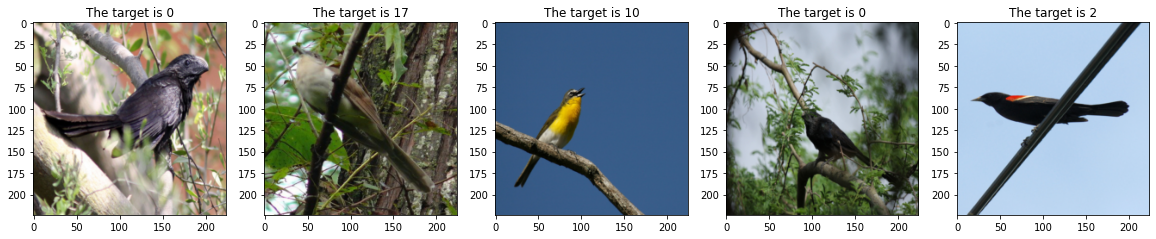

In [67]:
fig, axs = plt.subplots(1, 5, figsize = (20,10))
for i, (images, targets) in zip(range(5), train_loader):
    num = random.randint(0, len(images) - 1)
    image, target = images[num], targets[num]
    imshow(image, axs[i])
    axs[i].set_title(f"The target is {target}")

As we can see in the vizualization of the images, we have some birds that takes just a little space in the image. In order to get rid of the noise around the bird, we will use a pretrained detection model **"YOLO"** that detects the bounding box of the bird so we can crop the image.

### **Apply YOLO on the dataset**

In [68]:
model_yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained = True)
model_yolo.conf = 0.4  # confidence threshold
model_yolo.multi_label = False  # NMS multiple labels per box
model_yolo.classes = [14]  # (optional list) filter by class, i.e. = [14] for COCO birds
model_yolo.max_det = 1  # maximum number of detections per image

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-29 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [69]:
def get_bbox(image):
    """
    A function that takes the path of the image and returns the bounding box of the bird
    """
    results = model_yolo(image)
    crops = results.crop(save=False)
    found_bird = False
    for crop in crops:
        label = crop['label']
        if len(crops) != 1:
            print(len(crops))
        if 'bird' in label:
            found_bird = True
            bbox = crops[0]['box']
    if found_bird:
        return bbox
    else:
        return None

In [70]:
def crop_image(image, bbox):
    """
    A function that takes the path of the image and the bounding box of the bird
    It returns a cropped image of the bird
    If the bird is detected so the function crops the image, otherwise it returns the orignal
    image
    """
    #check if a bird is found by YOLO
    if bbox:
        x_min, y_min = bbox[0].item(), bbox[1].item()
        x_max, y_max = bbox[2].item(), bbox[3].item()
        cropped_image = image.crop((x_min, y_min, x_max, y_max))
        cropped_image = cropped_image.resize((224, 224))
        return np.array(cropped_image)
    
    else:
        return np.array(image)

In [71]:
def get_yolo_dataset(data_loader):
    """
    This function iterates over the dataset and returns a new one with croped images
    using YOLO
    """
    new_dataset = []
    yolo_images = []
    yolo_targets = []
    for batch_idx, (images, targets) in enumerate(data_loader):
        for image, target in zip(images, targets):
            image1 = image.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image1 = std * image1 + mean
            image1 = Image.fromarray((image1 * 255).astype(np.uint8))
            bbox = get_bbox(image1)
            cropped_image = crop_image(image1, bbox)
            cropped_image = cropped_image.transpose((2, 0, 1))
            yolo_images.append(cropped_image)
            yolo_targets.append(target)
    tensor_images = torch.tensor(yolo_images)
    tensor_targets = torch.tensor(yolo_targets)
    tensor_dataset = torch.utils.data.TensorDataset(tensor_images,tensor_targets)
    return tensor_dataset

In [72]:
train_dataset_yolo = get_yolo_dataset(train_loader)
val_dataset_yolo = get_yolo_dataset(val_loader)

In [73]:
train_yolo_loader = torch.utils.data.DataLoader(train_dataset_yolo, batch_size = 32)
val_yolo_loader = torch.utils.data.DataLoader(val_dataset_yolo, batch_size = 32)

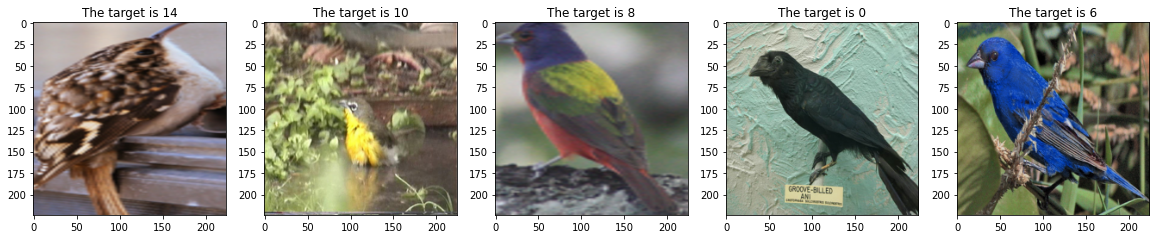

In [74]:
fig, axs = plt.subplots(1, 5, figsize = (20,10))
for i, (images, targets) in zip(range(5), train_yolo_loader):
    num = random.randint(0, len(images) - 1)
    image, target = images[num], targets[num]
    image = image.numpy().transpose((1, 2, 0))
    axs[i].imshow(image)
    axs[i].set_title(f"The target is {target}")

As we can see in the previous images, there are some birds that are cropped well but the other ones are not cropped. In fact, this is due to the confidence probability we have set to 0.4. Yolo might detect the bird but maybe with lower probabilty. Additionally, we can lower the confidence probabilty but sometimes YOLO detects other objects as birds. Then, after doing some experiments we have used 0.4 as a confidence probability.

# **Transfer Learning with Pytorch**

### Trial 1 : **Apply a pretrained model on YOLO dataset**

In [75]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [76]:
model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [77]:
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Sequential(
    nn.Linear(num_ftrs, 100),
    nn.Dropout(0.5),
    nn.Linear(100, 50),
    nn.Dropout(0.5),
    nn.Linear(50, 20))

model_ft = model_ft.to(device)

optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001)

In [78]:
def train(model, epoch, data_loader):
    model.train()
    correct = 0
    training_loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        if use_cuda:
            data, target = data.float().cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        loss = criterion(output, target)
        training_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    training_loss /= len(data_loader.dataset)
    print('\nTraining set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        training_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
        
def validation(model, data_loader):
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in data_loader:
        if use_cuda:
            data, target = data.float().cuda(), target.cuda()
        output = model(data)
        # sum up batch loss
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        validation_loss += criterion(output, target).data.item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(data_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

def start_model(model, num_epochs, train_loader, val_loader):
    for epoch in range(1, num_epochs + 1):
        train(model, epoch, train_loader)
        validation(model, val_loader)
        model_file = EXPERIMENT + '/model_' + str(epoch) + '.pth'
        torch.save(model_ft.state_dict(), model_file)
        print('Saved model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file\n')


In [79]:
start_model(model_ft, 30, train_yolo_loader, val_yolo_loader)


Training set: Average loss: 0.0818, Accuracy: 221/1082 (20%)

Validation set: Average loss: 0.0627, Accuracy: 58/103 (56%)
Saved model to experiment/model_1.pth. You can run `python evaluate.py --model experiment/model_1.pth` to generate the Kaggle formatted csv file


Training set: Average loss: 0.0543, Accuracy: 492/1082 (45%)

Validation set: Average loss: 0.0595, Accuracy: 57/103 (55%)
Saved model to experiment/model_2.pth. You can run `python evaluate.py --model experiment/model_2.pth` to generate the Kaggle formatted csv file


Training set: Average loss: 0.0446, Accuracy: 587/1082 (54%)

Validation set: Average loss: 0.0469, Accuracy: 58/103 (56%)
Saved model to experiment/model_3.pth. You can run `python evaluate.py --model experiment/model_3.pth` to generate the Kaggle formatted csv file


Training set: Average loss: 0.0371, Accuracy: 675/1082 (62%)

Validation set: Average loss: 0.0416, Accuracy: 65/103 (63%)
Saved model to experiment/model_4.pth. You can run `python evaluat

### **Second trial : Apply a pretrained model on YOLO dataset**

In this part, we will augment data then we will apply yolo.

In [80]:
transforms_train_augment = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(15),
        transforms.RandomRotation([90, 180]),
        transforms.RandomVerticalFlip(0.5),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(brightness=0.7, contrast=0.2, saturation=0.5, hue = 0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

transforms_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [82]:
train_loader_augment = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(DATA + '/train_images',
                         transform = transforms_train_augment),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(DATA + '/val_images',
                         transform = transforms_val),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

In [83]:
train_dataset_yolo_augmented = get_yolo_dataset(train_loader)
train_yolo_loader_augmented = torch.utils.data.DataLoader(train_dataset_yolo_augmented, batch_size = 32)

In [84]:
model_ft2 = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [85]:
num_ftrs = model_ft2.classifier[1].in_features
model_ft2.classifier[1] = nn.Sequential(
    nn.Linear(num_ftrs, 100),
    nn.Dropout(0.5),
    nn.Linear(100, 50),
    nn.Dropout(0.5),
    nn.Linear(50, 20))

model_ft2 = model_ft2.to(device)

optimizer = torch.optim.Adam(model_ft2.parameters(), lr=0.001)

In [86]:
start_model(model_ft2, 30, train_yolo_loader_augmented, val_yolo_loader)


Training set: Average loss: 0.0817, Accuracy: 232/1082 (21%)

Validation set: Average loss: 0.0706, Accuracy: 43/103 (42%)
Saved model to experiment/model_1.pth. You can run `python evaluate.py --model experiment/model_1.pth` to generate the Kaggle formatted csv file


Training set: Average loss: 0.0592, Accuracy: 436/1082 (40%)

Validation set: Average loss: 0.0506, Accuracy: 63/103 (61%)
Saved model to experiment/model_2.pth. You can run `python evaluate.py --model experiment/model_2.pth` to generate the Kaggle formatted csv file


Training set: Average loss: 0.0459, Accuracy: 582/1082 (54%)

Validation set: Average loss: 0.0449, Accuracy: 65/103 (63%)
Saved model to experiment/model_3.pth. You can run `python evaluate.py --model experiment/model_3.pth` to generate the Kaggle formatted csv file


Training set: Average loss: 0.0367, Accuracy: 677/1082 (63%)

Validation set: Average loss: 0.0537, Accuracy: 60/103 (58%)
Saved model to experiment/model_4.pth. You can run `python evaluat

# **Vision Transformers with Huggingface**

### **Import the pretrained model : Vision Transformer**

Since we will be using a pretrained vision transformer model, so we will need to feed the correct form of images to the model. To do so, we will call a feature extractor that takes an image and transform it as the our model wants it to be.
Additionally, to apply YOLO on the original dataset we will need to change a little the function already implemented earlier in order to prepare it as ViT inputs has to be.

In [87]:
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

### Upload the original dataset

In [88]:
#Get the original dataset
train_ds = load_dataset("/kaggle/input/birddataset/bird_dataset/train_images")
val_ds = load_dataset("/kaggle/input/birddataset/bird_dataset/val_images")

Resolving data files:   0%|          | 0/1082 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [89]:
train_ds = train_ds['train']
val_ds = val_ds['train']

In [90]:
from datasets import Dataset, Image, Features, ClassLabel
import PIL.Image as img 
feature = Image()

In [91]:
def get_yolo_dataset(ds):
    """
    This function iterates over the dataset and returns a new one with cropped images
    using YOLO
    """
    new_dataset = []
    yolo_images = []
    for item in ds:
        image = item['image']
        label = item['label']
        bbox = get_bbox(image)
        cropped_image = img.fromarray(crop_image(image, bbox))
        dict_image = {'image' : feature.encode_example(cropped_image), 'label' : label}
        yolo_images.append(dict_image)
    return yolo_images

In [92]:
list_yolo_train = get_yolo_dataset(train_ds)
list_yolo_val = get_yolo_dataset(val_ds)
train_df = pd.DataFrame(list_yolo_train)
val_df = pd.DataFrame(list_yolo_val)

In [93]:
features = Features({"image": Image(),
            "label": ClassLabel(num_classes=20, names=['004.Groove_billed_Ani', '009.Brewer_Blackbird', '010.Red_winged_Blackbird', '011.Rusty_Blackbird', '012.Yellow_headed_Blackbird', '013.Bobolink', '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting', '019.Gray_Catbird', '020.Yellow_breasted_Chat', '021.Eastern_Towhee', '023.Brandt_Cormorant', '026.Bronzed_Cowbird', '028.Brown_Creeper', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo', '033.Yellow_billed_Cuckoo', '034.Gray_crowned_Rosy_Finch'], id=None),
            })
train_ds_yolo = Dataset.from_pandas(train_df, features)
val_ds_yolo = Dataset.from_pandas(val_df, features)

#### **Little check on the results**

In [94]:
num = random.randint(0, 1082)

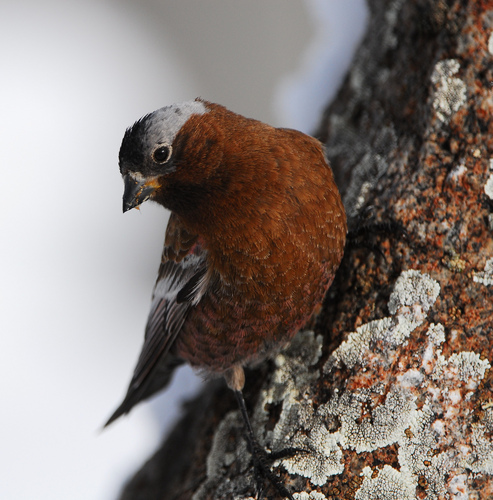

In [95]:
train_ds['image'][num]

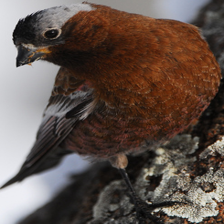

In [96]:
train_ds_yolo['image'][num]

One image in the original dataset is not in a RGB mode, so the model does not accept it as an input. The following code consists of getting this image and delete it from the original dataset.

In [97]:
to_delete = []
for i, image in enumerate(train_ds):
    image = train_ds[i]['image']
    if image.mode != "RGB":
        to_delete.append(i)
print(to_delete)

[69]


In [98]:
train_ds = train_ds.select(
    (
        i for i in range(len(train_ds)) 
        if i not in set(to_delete)
    )
)

### **Prepare the data**

In [99]:
def transform(batch_images):
    """
    A function that takes a batch of images and transform each of them to pixel values 
    with the corresponding label
    """
    values = feature_extractor([x.convert("RGB") for x in batch_images['image']], return_tensors='pt')
    values['label'] = batch_images['label']
    return values

In [100]:
# Now we transform the datasets using the previous function
transformed_train_ds = train_ds.with_transform(transform)
transformed_val_ds = val_ds.with_transform(transform)

transformed_train_ds_yolo = train_ds_yolo.with_transform(transform)
transformed_val_ds_yolo = val_ds_yolo.with_transform(transform)

In [101]:
def collate(batch_images):
    """
    This function define the data collator of our model
    It takes a batch of images and stacks them in a tensor and it does the same
    for the corresponding labels.
    """
    collated = {
        'pixel_values': torch.stack([image['pixel_values'] for image in batch_images]),
        'labels': torch.tensor([image['label'] for image in batch_images])
    }
    return collated

In [102]:
#In order to evaluate our model, we will use the accuracy metric 
metric = load_metric("accuracy")
def compute_metrics(p):
    """
    Since the output of the model is a list of probabilities, then we will need to get the
    class with higher probability. 
    """
    score = metric.compute(predictions = np.argmax(p.predictions, axis=1), references=p.label_ids)
    return score

In [103]:
#Extarct the names of the labels of our dataset 
labels = train_ds.features['label'].names

#Get the necessary ingredients for the model
num_labels = len(labels)
id2label = {str(idx): name for idx, name in enumerate(labels)}
label2id = {name: str(idx) for idx, name in enumerate(labels)}

#Initialize the model to use
model1 = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = len(labels),
    id2label= id2label,
    label2id = label2id,
)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [104]:
training_args = TrainingArguments(
  output_dir="./experiments",
  per_device_train_batch_size=32,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  num_train_epochs=20,
  fp16=True,
  save_steps=20,
  eval_steps=20,
  logging_steps=10,
  learning_rate= 2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
label_smoothing_factor=0.1
)

### **Train and validate on the original dataset**

In [105]:
trainer = Trainer(
    model=model1,
    args=training_args,
    data_collator=collate,
    compute_metrics=compute_metrics,
    train_dataset=transformed_train_ds,
    eval_dataset=transformed_val_ds,
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [106]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1081
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 340


Epoch,Training Loss,Validation Loss,Accuracy
1,2.693800,1.977026,0.883495
2,1.554000,1.358008,0.902913
3,0.997600,1.075157,0.893204
4,0.837200,0.968478,0.893204
5,0.707200,0.935793,0.912621
6,0.654300,0.940617,0.873786
7,0.640000,0.992921,0.854369
8,0.616600,0.981945,0.844660
9,0.606900,0.984923,0.873786
10,0.602400,0.983824,0.864078


***** Running Evaluation *****
  Num examples = 103
  Batch size = 16
Saving model checkpoint to ./experiments/checkpoint-17
Configuration saved in ./experiments/checkpoint-17/config.json
Model weights saved in ./experiments/checkpoint-17/pytorch_model.bin
Feature extractor saved in ./experiments/checkpoint-17/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 103
  Batch size = 16
Saving model checkpoint to ./experiments/checkpoint-34
Configuration saved in ./experiments/checkpoint-34/config.json
Model weights saved in ./experiments/checkpoint-34/pytorch_model.bin
Feature extractor saved in ./experiments/checkpoint-34/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 103
  Batch size = 16
Saving model checkpoint to ./experiments/checkpoint-51
Configuration saved in ./experiments/checkpoint-51/config.json
Model weights saved in ./experiments/checkpoint-51/pytorch_model.bin
Feature extractor saved in ./experiments/checkpoint-51/preprocessor_c

***** train metrics *****
  epoch                    =         20.0
  total_flos               = 1560567972GF
  train_loss               =       0.7834
  train_runtime            =   0:07:36.52
  train_samples_per_second =       47.358
  train_steps_per_second   =        0.745


### **Train and validate on the cropped dataset**

In [165]:
model2 = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = len(labels),
    id2label= id2label,
    label2id = label2id,
)

loading configuration file https://huggingface.co/google/vit-base-patch16-224-in21k/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/7bba26dd36a6ff9f6a9b19436dec361727bea03ec70fbfa82b70628109163eaa.92995a56e2eabab0c686015c4ad8275b4f9cbd858ed228f6a08936f2c31667e7
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "004.Groove_billed_Ani",
    "1": "009.Brewer_Blackbird",
    "10": "020.Yellow_breasted_Chat",
    "11": "021.Eastern_Towhee",
    "12": "023.Brandt_Cormorant",
    "13": "026.Bronzed_Cowbird",
    "14": "028.Brown_Creeper",
    "15": "029.American_Crow",
    "16": "030.Fish_Crow",
    "17": "031.Black_billed_Cuckoo",
    "18": "033.Yellow_billed_Cuckoo",
    "19": "034.Gray_crowned_Rosy_Finch",
    "2": "010.Red_winge

In [169]:
training_args = TrainingArguments(
  output_dir="./experiments",
  per_device_train_batch_size=32,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  num_train_epochs=20,
  fp16=True,
  save_steps=20,
  eval_steps=20,
  logging_steps=10,
  learning_rate= 2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
label_smoothing_factor=0.1
)

PyTorch: setting up devices


In [170]:
trainer = Trainer(
    model=model2,
    args=training_args,
    data_collator=collate,
    compute_metrics=compute_metrics,
    train_dataset=transformed_train_ds_yolo,
    eval_dataset=transformed_val_ds_yolo,
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [171]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1082
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 340


Epoch,Training Loss,Validation Loss,Accuracy
1,1.696300,1.317361,0.932039
2,1.017700,1.009466,0.912621
3,0.744700,0.936822,0.912621
4,0.688100,0.846271,0.932039
5,0.631500,0.828262,0.932039
6,0.611700,0.818890,0.922330
7,0.606700,0.815194,0.912621
8,0.600900,0.812022,0.922330
9,0.597900,0.810043,0.912621
10,0.596400,0.810128,0.912621


***** Running Evaluation *****
  Num examples = 103
  Batch size = 16
Saving model checkpoint to ./experiments/checkpoint-17
Configuration saved in ./experiments/checkpoint-17/config.json
Model weights saved in ./experiments/checkpoint-17/pytorch_model.bin
Feature extractor saved in ./experiments/checkpoint-17/preprocessor_config.json
Deleting older checkpoint [experiments/checkpoint-102] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 103
  Batch size = 16
Saving model checkpoint to ./experiments/checkpoint-34
Configuration saved in ./experiments/checkpoint-34/config.json
Model weights saved in ./experiments/checkpoint-34/pytorch_model.bin
Feature extractor saved in ./experiments/checkpoint-34/preprocessor_config.json
Deleting older checkpoint [experiments/checkpoint-119] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 103
  Batch size = 16
Saving model checkpoint to ./experiments/checkpoint-51
Configuration saved in ./experime

***** train metrics *****
  epoch                    =         20.0
  total_flos               = 1562011606GF
  train_loss               =       0.6804
  train_runtime            =   0:05:50.36
  train_samples_per_second =       61.764
  train_steps_per_second   =         0.97


# **Inference**

In [172]:
 best_model = model2.from_pretrained("./experiments/checkpoint-204")

loading configuration file ./experiments/checkpoint-204/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "004.Groove_billed_Ani",
    "1": "009.Brewer_Blackbird",
    "2": "010.Red_winged_Blackbird",
    "3": "011.Rusty_Blackbird",
    "4": "012.Yellow_headed_Blackbird",
    "5": "013.Bobolink",
    "6": "014.Indigo_Bunting",
    "7": "015.Lazuli_Bunting",
    "8": "016.Painted_Bunting",
    "9": "019.Gray_Catbird",
    "10": "020.Yellow_breasted_Chat",
    "11": "021.Eastern_Towhee",
    "12": "023.Brandt_Cormorant",
    "13": "026.Bronzed_Cowbird",
    "14": "028.Brown_Creeper",
    "15": "029.American_Crow",
    "16": "030.Fish_Crow",
    "17": "031.Black_billed_Cuckoo",
    "18": "033.Yellow_billed_Cuckoo",
    "19": "03

In [118]:
import argparse
from tqdm import tqdm
import os
import PIL.Image as Image

In [173]:
test_dir = '/kaggle/input/birddataset/bird_dataset/test_images'
test_ds = load_dataset(test_dir)

Resolving data files:   0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [174]:
test_ds = test_ds['train']
list_yolo_test = get_yolo_dataset(test_ds)
test_df = pd.DataFrame(list_yolo_test)
test_ds_yolo = Dataset.from_pandas(test_df, features)

In [140]:
transformed_test_ds = test_ds_yolo.with_transform(transform)

#### **Little check on the results**

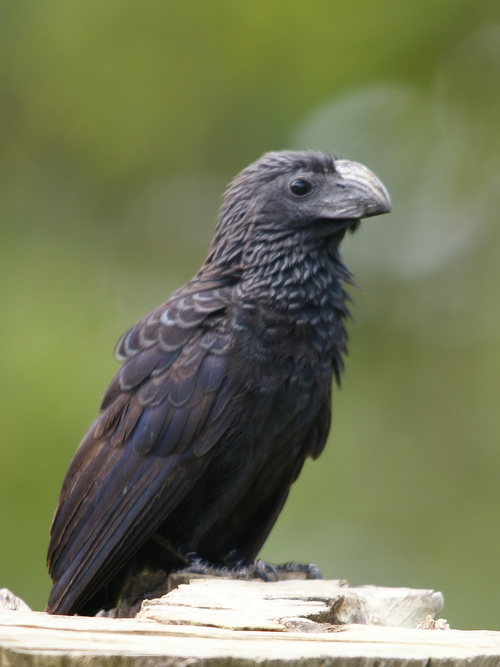

In [175]:
num = random.randint(0, 516)
test_ds[num]["image"]

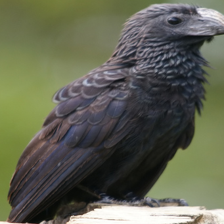

In [176]:
test_ds_yolo[num]['image']

In [177]:
EXPERIMENT = "experiment"
if not os.path.isdir(EXPERIMENT):
    os.makedirs(EXPERIMENT)

In [178]:
test_dir = "/kaggle/input/birddataset/bird_dataset/test_images/mistery_category"
ids = [f for f in os.listdir(test_dir)]
ids = sorted(ids)

In [179]:
OUTFILE = './kaggle2.csv'
#args = parser.parse_args()
use_cuda = torch.cuda.is_available()

output_file = open(OUTFILE, "w")
output_file.write("Id,Category\n")

for idx, f in tqdm(enumerate(ids)):
    if 'jpg' in f:
        image = test_ds_yolo[idx]["image"]
        inputs = feature_extractor(image, return_tensors='pt')
        predictions = best_model(**inputs).logits
        predicted_label = predictions.argmax(-1).item()
        output_file.write("%s,%d\n" % (f[:-4], predicted_label))

output_file.close()

print("Succesfully wrote " + OUTFILE + ', you can upload this file to the kaggle competition website')

517it [03:43,  2.32it/s]

Succesfully wrote ./kaggle2.csv, you can upload this file to the kaggle competition website
